<a href="https://colab.research.google.com/github/asyifahafizahumm-lab/uapml081/blob/main/UAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup & Import Library


In [ ]:
!pip install scikit-learn matplotlib seaborn --quiet

import os, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16, MobileNetV2
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

print(tf.__version__)  # harusnya keluar 2.19.0 atau versi 2.x lain


2.19.0


# 2. Atur Path Dataset & Parameter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_dir = "/content/drive/My Drive/Colab Notebooks/UAP/archive/data"
# di dalam `data` ada folder: with_mask dan without_mask

img_height, img_width = 128, 128
batch_size = 32
num_classes = 2  # with_mask, without_mask


Mounted at /content/drive


# 3. Data Generator TANPA Augmentasi (Train / Val / “Test”)

In [ ]:
# --- Untuk model base CNN (rescale biasa) ---
train_datagen_base = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2   # 80% train, 20% val
)

train_gen_base = train_datagen_base.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_gen_base = train_datagen_base.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

# untuk “test”, dipakai val_gen_base (kalau belum punya folder test terpisah)
test_gen_base = val_gen_base

class_indices = train_gen_base.class_indices
print("Class indices:", class_indices)


Found 2980 images belonging to 2 classes.
Found 745 images belonging to 2 classes.
Class indices: {'with_mask': 0, 'without_mask': 1}


# 4. Fungsi Helper: Plot & Evaluasi

In [ ]:
def plot_history(history, title_prefix="Model"):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b-', label='Train acc')
    plt.plot(epochs, val_acc, 'r-', label='Val acc')
    plt.title(f"{title_prefix} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b-', label='Train loss')
    plt.plot(epochs, val_loss, 'r-', label='Val loss')
    plt.title(f"{title_prefix} Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

def evaluate_model(model, test_gen, class_indices, title_prefix="Model"):
    test_gen.reset()
    pred_probs = model.predict(test_gen)
    y_pred = np.argmax(pred_probs, axis=1)
    y_true = test_gen.classes
    labels = list(class_indices.keys())

    # Get all possible numeric labels from class_indices
    all_numeric_labels = sorted(class_indices.values())

    print(f"Classification Report - {title_prefix}")
    # Pass 'labels' explicitly to ensure all classes are reported,
    # even if some are missing in y_true or y_pred.
    print(classification_report(y_true, y_pred, target_names=labels, labels=all_numeric_labels, zero_division=0))

    # Pass 'labels' to confusion_matrix as well
    cm = confusion_matrix(y_true, y_pred, labels=all_numeric_labels)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.title(f"Confusion Matrix - {title_prefix}")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

# 5. Model 1 – CNN Base (Non-Pretrained)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,482,626 (32.36 MB)

 Trainable params: 8,482,626 (32.36 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 4/94 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.5931 - loss: 0.4342

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 58s 552ms/step - accuracy: 0.9577 - loss: 0.0490 - val_accuracy: 1.0000 - val_loss: 3.1063e-06
Epoch 2/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 1.0000 - loss: 1.8910e-06 - val_accuracy: 1.0000 - val_loss: 1.8917e-06
Epoch 3/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - accuracy: 1.0000 - loss: 4.3449e-06 - val_accuracy: 1.0000 - val_loss: 1.1864e-06
Epoch 4/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 1.0000 - loss: 1.7298e-06 - val_accuracy: 1.0000 - val_loss: 7.7995e-07
Epoch 5/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 224ms/step - accuracy: 1.0000 - loss: 1.4155e-06 - val_accuracy: 1.0000 - val_loss: 5.6478e-07
Epoch 6/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 1.0000 - loss: 6.2112e-07 - val_accuracy: 1.0000 - val_loss: 3.8896e-07
Epoch 7/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 1.0000 - loss: 1.0533e-06 - val_accuracy: 1.0000 - val_loss: 2.7425e-07
Epoch 8/20
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - a

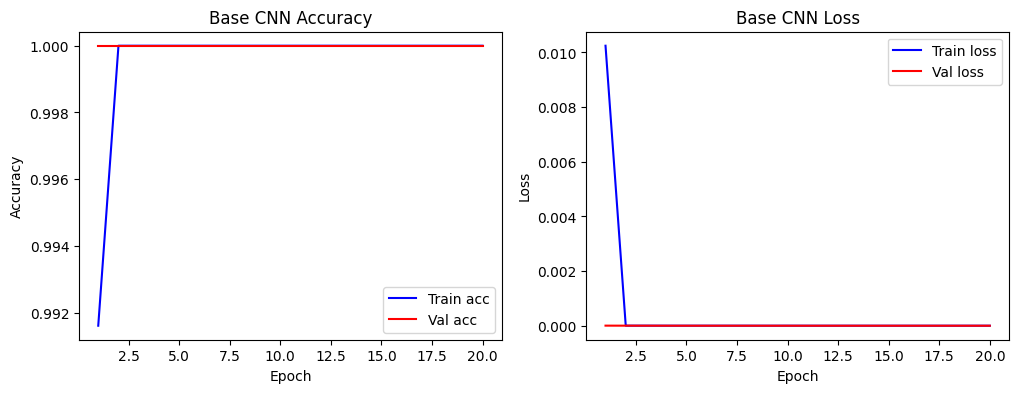

24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step
Classification Report - Base CNN
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       745

    accuracy                           1.00       745
   macro avg       1.00      1.00      1.00       745
weighted avg       1.00      1.00      1.00       745



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


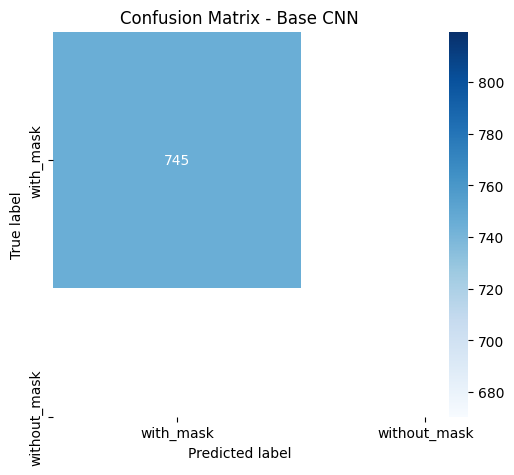

In [ ]:
# --- pastikan num_classes = 2 di atas ---
def build_base_cnn(input_shape=(img_height, img_width, 3), num_classes=num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', padding='same',
                      input_shape=input_shape),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.MaxPooling2D((2,2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


# --- fungsi evaluate_model versi aman (tanpa target_names tetap) ---
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model(model, test_gen, class_indices, title_prefix="Model"):
    test_gen.reset()
    pred_probs = model.predict(test_gen)
    y_pred = np.argmax(pred_probs, axis=1)
    y_true = test_gen.classes

    print(f"Classification Report - {title_prefix}")
    # tidak pakai target_names agar tidak error jika hanya 1 kelas yang muncul
    print(classification_report(y_true, y_pred))

    labels = list(class_indices.keys())
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d",
                xticklabels=labels, yticklabels=labels, cmap="Blues")
    plt.title(f"Confusion Matrix - {title_prefix}")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


# --- training model base CNN ---
base_cnn = build_base_cnn()
base_cnn.summary()

epochs_base = 20

history_base = base_cnn.fit(
    train_gen_base,
    epochs=epochs_base,
    validation_data=val_gen_base
)

# --- plot dan evaluasi ---
plot_history(history_base, title_prefix="Base CNN")
evaluate_model(base_cnn, test_gen_base, class_indices, title_prefix="Base CNN")


# 6. Model 2 – Transfer Learning VGG16

Found 2980 images belonging to 2 classes.
Found 745 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,097,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,812,610 (64.14 MB)

 Trainable params: 2,097,922 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
33/94 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step - accuracy: 0.9220 - loss: 1.5643

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 281ms/step - accuracy: 0.9650 - loss: 0.7002 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 204ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 203ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 200ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - accuracy: 1.0000 - loss: 7.5632e-11 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - a

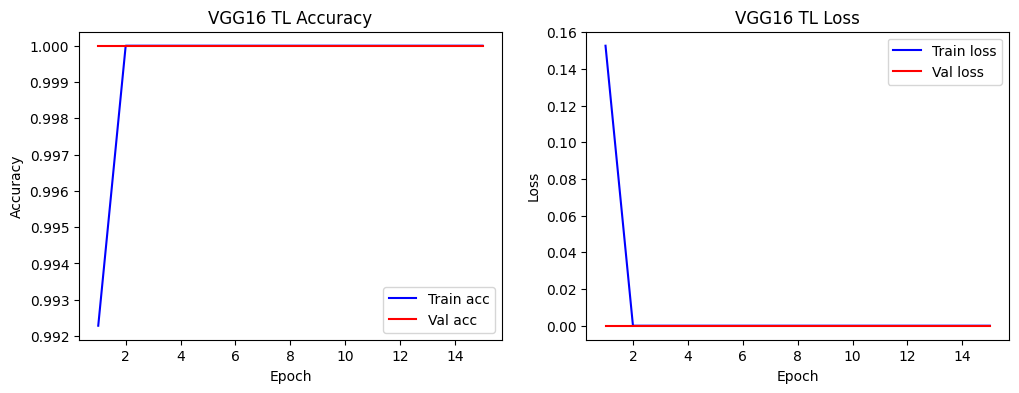

24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step
Classification Report - VGG16 TL
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       745

    accuracy                           1.00       745
   macro avg       1.00      1.00      1.00       745
weighted avg       1.00      1.00      1.00       745



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


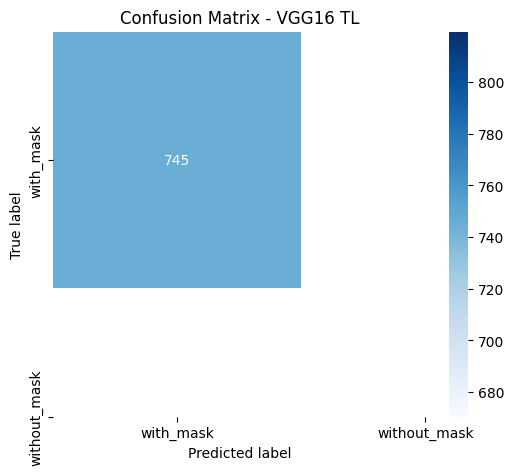

In [ ]:
train_datagen_vgg = ImageDataGenerator(
    preprocessing_function=vgg_preprocess,
    validation_split=0.2
)

train_gen_vgg = train_datagen_vgg.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_gen_vgg = train_datagen_vgg.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

test_gen_vgg = val_gen_vgg  # pakai val sebagai test

def build_vgg16_model(input_shape=(img_height, img_width, 3), num_classes=num_classes):
    base_model = VGG16(weights="imagenet", include_top=False,
                       input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = layers.Flatten()(base_model.output)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

vgg_model = build_vgg16_model()
vgg_model.summary()

epochs_vgg = 15

history_vgg = vgg_model.fit(
    train_gen_vgg,
    epochs=epochs_vgg,
    validation_data=val_gen_vgg
)

plot_history(history_vgg, title_prefix="VGG16 TL")
evaluate_model(vgg_model, test_gen_vgg, class_indices, title_prefix="VGG16 TL")


# 7. Model 3 – Transfer Learning MobileNetV2

Found 2980 images belonging to 2 classes.
Found 745 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
42/94 ━━━━━━━━━━━━━━━━━━━━ 7s 152ms/step - accuracy: 0.8277 - loss: 0.3727

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


94/94 ━━━━━━━━━━━━━━━━━━━━ 59s 462ms/step - accuracy: 0.8862 - loss: 0.2592 - val_accuracy: 1.0000 - val_loss: 0.0092
Epoch 2/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 197ms/step - accuracy: 0.9991 - loss: 0.0157 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 3/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 1.0000 - loss: 0.0068 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 4/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 1.0000 - loss: 0.0044 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 5/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 197ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 1.0000 - val_loss: 8.0130e-04
Epoch 6/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 191ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 5.9824e-04
Epoch 7/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 192ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 4.6545e-04
Epoch 8/15
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 201ms/step - accuracy: 1.0000 - loss: 0.0012 - val_acc

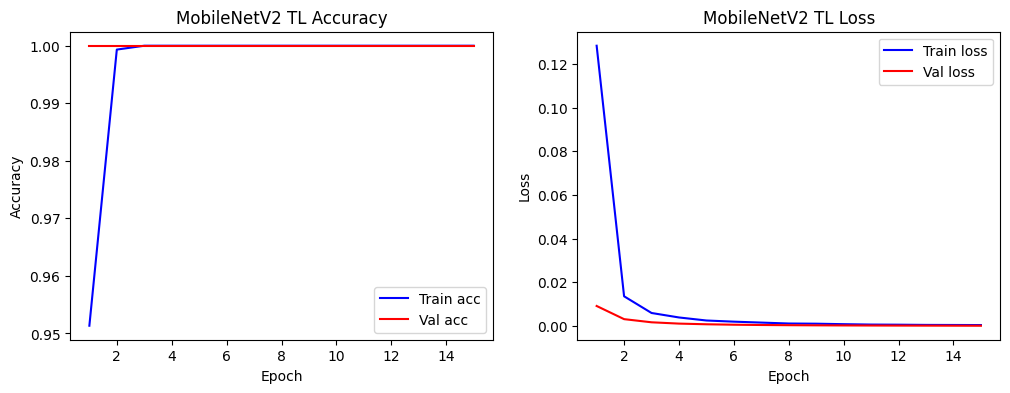

24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 323ms/step
Classification Report - MobileNetV2 TL
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       745

    accuracy                           1.00       745
   macro avg       1.00      1.00      1.00       745
weighted avg       1.00      1.00      1.00       745



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


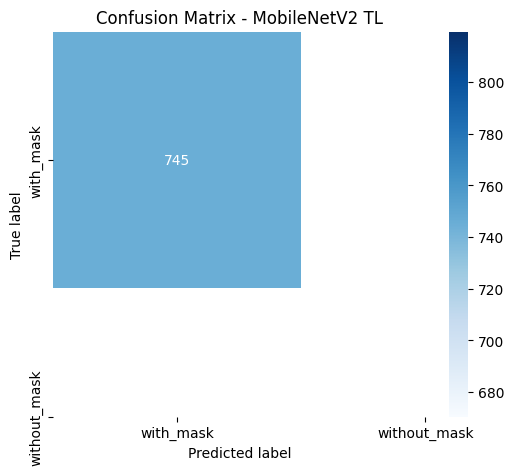

In [ ]:
train_datagen_mn = ImageDataGenerator(
    preprocessing_function=mobilenet_preprocess,
    validation_split=0.2
)

train_gen_mn = train_datagen_mn.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_gen_mn = train_datagen_mn.flow_from_directory(
    base_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation"
)

test_gen_mn = val_gen_mn  # pakai val sebagai test

def build_mobilenet_model(input_shape=(img_height, img_width, 3), num_classes=num_classes):
    base_model = MobileNetV2(weights="imagenet", include_top=False,
                             input_shape=input_shape)
    base_model.trainable = False

    x = layers.GlobalAveragePooling2D()(base_model.output)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=base_model.input, outputs=outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

mn_model = build_mobilenet_model()
mn_model.summary()

epochs_mn = 15

history_mn = mn_model.fit(
    train_gen_mn,
    epochs=epochs_mn,
    validation_data=val_gen_mn
)

plot_history(history_mn, title_prefix="MobileNetV2 TL")
evaluate_model(mn_model, test_gen_mn, class_indices, title_prefix="MobileNetV2 TL")


In [ ]:
base_cnn.save("base_cnn.h5")
vgg_model.save("vgg16_mask.h5")
mn_model.save("mobilenetv2_mask.h5")


In [ ]:
from google.colab import files
base_cnn.save("base_cnn.h5")
vgg_model.save("vgg16_mask.h5")
mn_model.save("mobilenetv2_mask.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!cp base_cnn.h5 "/content/drive/My Drive/Colab Notebooks/UAP/"
!cp vgg16_mask.h5 "/content/drive/My Drive/Colab Notebooks/UAP/"
!cp mobilenetv2_mask.h5 "/content/drive/My Drive/Colab Notebooks/UAP/"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
